In [1]:
# !pip install langchain
# !pip install openai -U
# !pip install nervaluate
# !pip install faiss
# !pip install tiktoken
# !pip install pandas
# !pip install sentence-transformers
# !pip install matplotlib

In [2]:
### THE OVERVIEW: 
# 1. Prompt in LLM.
# 2. Convert the receipt text structured data
# 3. Use labels and K-nearest neighbors (embeddings) to classify the vendor into vendor categories.
# 4. Classify the items into categories; propose your own .
# 5. Plot these analytics of vendors and items.

In [1]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.embeddings import HuggingFaceEmbeddings
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os

In [4]:
prompt = """
Can you please convert this unstructured receipt text data into a structured JSON object which includes ReceiptInfo and ITEMS.
Note that sometimes the quantity for an item may be located next to the item name.
Text in the structured JSON should appear in the same format as the unstructured receipt.
Please just give the structured JSON object and nothing else.

Here is the schema for the JSON object:
{{
  "ReceiptInfo": {{
    "merchant": "(string value)",
    "address": "(string value)",
    "city": "(string value)",
    "state": "(string value)",
    "phoneNumber": "(string value)",
    "tax": "(float value)",
    "total": "(float value)",
    "receiptDate": "(string value)",
    "receiptTime": "(string value)",


    "ITEMS": [
      {{
        "description": "(string value)",
        "quantity": "(integer value)",
        "unitPrice": "(float value)",
        "totalPrice": "(float value)",
        "discountAmount": "(float value)"
      }}
    ]
  }}
}}


Examples:

Receipt:
Give us feedback @ <UNKNOWN>
Thank you! ID <UNKNOWN> <UNKNOWN>
Walmart
301-604-0180 Mgr:DEBRA
3549 RUSSETT GRN
LAUREL MD 20724
ST# 01985 OP# 009049 TE# 49 TR# 04345
<UNKNOWN> PRK SB 008265754333 F
1.98 X
BOOSTER
088439295372
19.98 N
VOIDED BANKCARD TRANSACTION
TERMINAL <UNKNOWN> SC010112
TRANSACTION NOT COMPLETE
07/04/23
16:19:53
<UNKNOWN> BANKCARD TRANSACTION
TERMINAL # SC010112
TRANSACTION <UNKNOWN> COMPLETE
07/04/23
16:20:01
SUBTOTAL
21.96
TAX 1
6.000 %
0.12
TOTAL
22.08
VISA TEND
22.08
ACCOUNT #
**** **** <UNKNOWN> 2130 F
APPROVAL # 00592D
REF # 318500762875
TRANS ID - 583185732192035
VALIDATION - B339
PAYMENT SERVICE - E
TERMINAL # SC010112
07/04/23
16:20:21
CHANGE DUE
0.00
# ITEMS SOLD 2
<UNKNOWN> 0069 6254 8220 4557 9869
Walmart
Become a member
Scan for free 30-day trial
Low Prices You Can <UNKNOWN> Every <UNKNOWN>
07/04/23
16:20:22
***CUSTOMER <UNKNOWN>

JSON:
{{
  "ReceiptInfo": {{
    "merchant": "Walmart",
    "address": "3549 RUSSETT GRN",
    "city": "LAUREL",
    "state": "MD",
    "phoneNumber": "301-604-0180",
    "tax": "0.12",
    "total": "22.08",
    "receiptDate": "07/04/23",
    "receiptTime": "4:20pm",


    "ITEMS": [
      {{
        "description": "PRK SB",
        "quantity": "1",
        "unitPrice": "1.98",
        "totalPrice": "1.98",
        "discountAmount": "0.00"
      }},
      {{
        "description": "BOOSTER",
        "quantity": "1",
        "unitPrice": "19.98",
        "totalPrice": "19.98",
        "discountAmount": "0.00"
      }}
    ]
  }}
}}

Receipt:
Unstructured Receipt Text Data:
203
BUY ONE GET ONE FREE QUARTER POUNDER
W/CHEESE OR EGG MCMUFFIN
Go to www.mcdvoice.com within 7 days
and tell <UNKNOWN> about your visit.
Validation Code:
Expires 30 days after receipt date.
Valid at participating US
Survey Code:
<UNKNOWN>
McDonald's Restaurant <UNKNOWN>
2915 E MANCA RD
<UNKNOWN> 96822
TEL# <UNKNOWN>
Thank You Valued Customer
KS# 2
08/19/2023 03:33 PM
<UNKNOWN>
Order 03
1 Happy Meal Ch Burger
5.89
1 Cheeseburger
ONLY Onions
ONLY Ketchup
1 Extra Kids Fry
1 Apple Juice
1 NERF
Subtotal
5.89
Tax
0.28
Take-Out Total
6.17
Cashless
6.17
Change
0.00
MER# 467782
CARD ISSUER
ACCOUNT
Visa SALE
<UNKNOWN> <UNKNOWN> 130
TRANSACTION AMOUNT
6.17
CONTACTLESS
AUTHORIZATION CODE - <UNKNOWN>
SEQ# 107204
AID: A0000000031010
McDonald's Restaurant
Sign up for MyMcDonald's rewards
to earn points on future visit

JSON:
{{
  "ReceiptInfo": {{
    "merchant": "McDonald's Restaurant",
    "address": "2915 E MANOA RD",
    "city": "Honolulu",
    "state": "HI",
    "phoneNumber": "",
    "tax": "0.28",
    "total": "6.17",
    "receiptDate": "08/19/2023",
    "receiptTime": "03:33 PM",


    "ITEMS": [
      {{
        "description": "Happy Meal Ch Burger",
        "quantity": "1",
        "unitPrice": "5.89",
        "totalPrice": "5.89",
        "discountAmount": "0.00"
      }}
    ]
  }}
}}

Receipt:
Unstructured Receipt Text Data:
H
<UNKNOWN>
MART
http://www.hmart.com
458 Keawe st
Honolulu, <UNKNOWN> 96813
TEL (808) 219-0924
Your Cashier was TIM
WANG DANGMYUN
4.99 B
K-T TOPPOKI
PC
6.99 B
OTG SOUP RICECAKE
7.99 B
HT VEGE DUMPLING
14.99 B
TAX
1.65
****
BALANCE
36.61
Discover Credit - C
ACCOUNT <UNKNOWN> ************ 1153
APPROVAL CODE: 01263R
SEQUENCE NUMBER: 22907
No CVM
Amount USD $36.61
CARD:Discover CREDIT XXXX1153 EMV
APPROVAL CODE : 01263R
AID A0000001523010
TVR : 0000008000
IAD <UNKNOWN>
TSI : E800
APPLICATION CRYPTOGRAM CB8F25799B68A2B
APPLICATION PREFERRED NAME Discover Cr
APPLICATION LABEL : Discover
TC CB8F25799B68A2B3
<UNKNOWN> 00
RespDate : 06112023
Resp Time 211509
<UNKNOWN>
TOTAL AMOUNT: $36.61
RESPONSE CODE: APPROVED
06/11/23 09:15pm 113 20
Discover
<UNKNOWN> 61
CHANGE
0.00
TOTAL NUMBER OF ITEMS SOLD =
4
06/11/23 09:15pm 81 20 363 113

JSON:
{{
  "ReceiptInfo": {{
    "merchant": "H MART",
    "address": "458 Keawe st",
    "city": "Honolulu",
    "state": "HI",
    "phoneNumber": "(808) 219-0924",
    "tax": "1.65",
    "total": "36.61",
    "receiptDate": "06/11/23",
    "receiptTime": "09:15pm",


    "ITEMS": [
      {{
        "description": "WANG DANGMYUN",
        "quantity": "1",
        "unitPrice": "4.99",
        "totalPrice": "4.99",
        "discountAmount": "0.00"
      }},
      {{
        "description": "K-T TOPPOKI PC",
        "quantity": "1",
        "unitPrice": "6.99",
        "totalPrice": "6.99",
        "discountAmount": "0.00"
      }},
      {{
        "description": "OTG SOUP RICECAKE",
        "quantity": "1",
        "unitPrice": "7.99",
        "totalPrice": "7.99",
        "discountAmount": "0.00"
      }},
      {{
        "description": "HT VEGE DUMPLING",
        "quantity": "1",
        "unitPrice": "14.99",
        "totalPrice": "14.99",
        "discountAmount": "0.00"
      }}
    ]
  }}
}}

Receipt:
SAFEWAY
O
<UNKNOWN>
Store 204 Dir Kaipo Ah Mook Sang
Main (808) 988-2058
2855 East Manoa Road
HONOLULU HI 96822
GROCERY
6.99 B
MARINARA SCE
Regular Price
8.49
Member Savings
1.50-
REFRIG/FROZEN
LUC CHES COLBY JAC.
10.99 B
Regular Price
13.49
Member Savings
2.50-
MARIE CALLENDER'S
4.00 B
Regular Price
6.49
Member Savings
2.49-
MEAT
AIDELLS MEATBALLS
5.99 B
Regular Price
8.99
Member Savings
3.00-
TAX
1.32
**** BALANCE
29.29
Credit Purchase 08/01/23 20:15
CARD # <UNKNOWN>
<UNKNOWN> 861544421300 AUTH: 0006375D
PAYMENT AMOUNT
29.29
AL VISA CREDIT
AID A0000000031010
TVR 0000000000
TSI 0000
Visa
29.29
CHANGE
0.00
TOTAL NUMBER OF ITEMS SOLD =
4
08/01/23 20:15 204 51 151
8851
Gameplays Earned 2
Sweepstakes Entries Earned 2
*Subject to limit of 10 <UNKNOWN> day
Earn gameplays and sweepstakes entries
by shopping, then play
Flavor Adventure for a chance to win!
Scan the QR code to Play. Win. Save.
REWARDS AVAILABLE
2
POINTS EARNED TODAY
Base Points 27
Total 27
Points Towards Next Reward 57 of 100
YOUR CASHIER TODAY WAS SELF
YOUR SAVINGS
Member Savings
Total
9.49
Total Savings Value
9.49
25%
Thank <UNKNOWN> you for shopping <UNKNOWN>
For SAFEWAY FOR U questions
877-276-9637 or Safeway.com/foru call

JSON:
{{
  "ReceiptInfo": {{
    "merchant": "SAFEWAY",
    "address": "2855 East Manoa Road",
    "city": "Honolulu",
    "state": "HI",
    "phoneNumber": "(808) 988-2058",
    "tax": "1.32",
    "total": "29.29",
    "receiptDate": "08/01/23",
    "receiptTime": "8:15pm",


    "ITEMS": [
      {{
        "description": "MARINARA SCE",
        "quantity": "1",
        "unitPrice": "8.49",
        "totalPrice": "6.99",
        "discountAmount": "1.50"
      }},
      {{
        "description": "LUC CHES COLBY JAC.",
        "quantity": "1",
        "unitPrice": "13.49",
        "totalPrice": "10.99",
        "discountAmount": "2.50"
      }},
      {{
        "description": "MARIE CALLENDER'S",
        "quantity": "1",
        "unitPrice": "6.49",
        "totalPrice": "4.00",
        "discountAmount": "2.49"
      }},
      {{
        "description": "AIDELLS MEATBALLS",
        "quantity": "1",
        "unitPrice": "8.99",
        "totalPrice": "5.99",
        "discountAmount": "3.00"
      }}
    ]
  }}
}}

Here is the Unstructured Receipt Text Data (Turn this into structured JSON):

Receipt: {receipt}
"""

In [5]:
def get_receipts():
    """Gets unstructured receipt text from each receipt text file in the receipts directory."""
    folder_path = 'receipts/text'
    receipts = []
    
    # List all files in the folder
    files = os.listdir(folder_path)
    
    # Iterate through each file
    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
    
        # Check if it's a text file
        if file_name.endswith('.txt'):
            with open(file_path, 'r') as file:
                # Read the content and append to the array
                text_content = file.read()
                receipts.append(text_content)
    
    return receipts

test_receipts = get_receipts()[0:5]

In [23]:
## Getting output from LLM.
# Uses OpenAI model.
model = ChatOpenAI()

# Creates a template for the prompt.
prompt_template = PromptTemplate.from_template(prompt)

# Inserts the prompt into model and gets output.
chain = LLMChain(llm=model, prompt=prompt_template)

def get_output(receipt):
    chain.run(receipt=receipt)

receipt_outputs = [chain.run(receipt=test_receipt) for test_receipt in test_receipts]
# receipt_outputs = get_output(test_receipts)
receipt_outputs

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


['{\n  "ReceiptInfo": {\n    "merchant": "SAFEWAY",\n    "address": "2855 East Manoa Road",\n    "city": "Honolulu",\n    "state": "HI",\n    "phoneNumber": "(808) 988-2058",\n    "tax": "0.21",\n    "total": "4.70",\n    "receiptDate": "05/26/22",\n    "receiptTime": "11:57am",\n\n\n    "ITEMS": [\n      {\n        "description": "LUCERNE MILK WHOLE",\n        "quantity": "1",\n        "unitPrice": "4.49",\n        "totalPrice": "4.49",\n        "discountAmount": "0.00"\n      }\n    ]\n  }\n}',
 '{\n  "ReceiptInfo": {\n    "merchant": "Sugar Sugar Hawaii",\n    "address": "4211 Waialae Ave., #W-2D",\n    "city": "Honolulu",\n    "state": "Hawaii",\n    "phoneNumber": "",\n    "tax": "1.71",\n    "total": "37.86",\n    "receiptDate": "Nov 04, 2023",\n    "receiptTime": "02:26 PM",\n\n\n    "ITEMS": [\n      {\n        "description": "Knitty Critters - Pouch Pals - Eddy",\n        "quantity": "1",\n        "unitPrice": "18.00",\n        "totalPrice": "18.00",\n        "discountAmount":

In [7]:
categories = ["Grocery and Supermarkets", "Restaurants and Food Services", "Clothing and Apparel", 
              "Health and Beauty", "Electronics and Appliances", "Home and Garden", "Entertainment and Leisure"]

def get_training_data():
    folder_path = 'training_data/'
    category_train_test_data = {}
    category_training_items = []
    
    # List all files in the folder
    files = os.listdir(folder_path)
    i = 0

    # Gets the items for each category.
    for category in categories:
        # Gets the file identifier for the category.
        category_id = (category.split(" ")[0]).lower()
        file_name = f'{category_id}_items.txt'
        file_path = os.path.join(folder_path, file_name)
    
        # Check if it's a text file.
        if file_name.endswith('.txt'):
            with open(file_path, 'r') as file:
                # Read the content and split into list by newline character.
                text_content = file.read().split('\n')
                # Adds the items to the category in the dict.
                category_train_test_data[categories[i]] = text_content
                i += 1
    return category_train_test_data

category_train_test_data = get_training_data()
category_training_embeddings = {}

embeddings_model = HuggingFaceEmbeddings()

for category in category_train_test_data:
    category_training_embeddings[category] = embeddings_model.embed_documents(category_train_test_data[category])

len(category_training_embeddings["Grocery and Supermarkets"])

362

In [8]:
"""
"Categories"                        "Embedding 1"     "Embedding 2" ....
-------------------------------------------------------------------------
"Grocery and Supermarkets"
"Grocery and Supermarkets"  
"Grocery and Supermarkets"  
"Grocery and Supermarkets"  
"Restaurants and Food Services"
"Restaurants and Food Services"
"Restaurants and Food Services"
"Clothing and Apparel" 
"Health and Beauty"
"Electronics and Appliances"
"Home and Garden"
"Entertainment and Leisure"
"""

df_category_items = []
d = {'categories':[]}

# Each category.
for category in category_training_embeddings:
    # Each item in the category.
    for item in category_training_embeddings[category]:
        df_category_items.append(category)

        # Each embedding in an item.
        for i in range(len(item)):
            embedding = item[i]

            if f'embedding_{i}' in d:
                d[f'embedding_{i}'].append(embedding)
            else:
                d[f'embedding_{i}'] = []
                d[f'embedding_{i}'].append(embedding)

d['categories'] = df_category_items
    
# Training and Testing data.
category_data = pd.DataFrame(d)

# 637 Items (Training (80%): 509, Testing (20%): 128)
category_data.shape

(2627, 769)

In [9]:
# Randomly shuffles the rows.
shuffled_data = category_data.sample(frac=1)

total_rows = shuffled_data.shape[0]
train_size = int(total_rows*0.8)
 
# Split data into test and train
train = shuffled_data[0:train_size]
test = shuffled_data[train_size:]

train

,categories,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
1079,Clothing and Apparel,0.011208,-0.041648,-0.028162,-0.008449,-0.026014,-0.014916,-0.028893,0.002488,-0.050067,...,-0.017504,0.006867,0.085442,0.000041,-0.006035,0.052250,0.000931,0.021905,-0.004071,-0.009820
174,Grocery and Supermarkets,0.040405,0.036593,-0.011941,-0.068947,-0.019148,0.042234,-0.088677,0.027187,0.031652,...,-0.049084,-0.014615,0.019407,-0.010918,0.023859,-0.054365,0.026855,0.005503,-0.018597,-0.045938
1596,Health and Beauty,0.049374,0.064438,0.014230,-0.016316,0.006914,-0.005651,0.020545,0.036349,-0.100884,...,-0.051885,-0.050634,0.030833,0.016863,-0.010515,0.095649,0.006829,-0.035837,-0.010677,0.014943
874,Clothing and Apparel,0.000566,0.074651,-0.004722,-0.054591,0.006295,0.021083,-0.002038,0.006574,-0.016203,...,-0.040902,-0.000985,0.055107,-0.009486,-0.027563,-0.036939,-0.005534,-0.026458,-0.012511,0.013300
753,Restaurants and Food Services,0.026920,-0.001203,0.004092,0.000102,-0.072044,-0.040365,-0.054901,0.036731,-0.065860,...,-0.046317,0.000853,0.035104,-0.027528,0.054123,0.033497,-0.001320,-0.013655,0.002730,0.025340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,Restaurants and Food Services,0.062472,0.021465,0.004194,-0.068010,-0.022641,-0.028480,-0.093650,0.013600,-0.052989,...,-0.054978,-0.016343,-0.003527,-0.033122,0.003888,0.080357,0.011895,-0.025385,0.064557,-0.026912
356,Grocery and Supermarkets,0.001079,0.015960,-0.017884,-0.009992,-0.013163,-0.025580,0.062642,0.016009,0.036003,...,0.000454,0.037693,0.020353,0.022793,-0.021006,0.037404,-0.007492,0.023509,-0.012040,-0.056464
2085,Home and Garden,-0.060477,0.017973,0.002439,0.005441,0.025376,-0.029641,0.033939,-0.032943,0.041606,...,-0.021569,0.011532,-0.003500,0.070987,0.022385,0.019840,0.087282,-0.000117,-0.005783,-0.011670
2063,Home and Garden,-0.032913,0.014894,0.011158,0.001887,0.037838,-0.014029,0.012051,-0.019383,0.016631,...,-0.027563,-0.005621,-0.015033,0.080579,0.021741,-0.000869,0.073355,0.006578,-0.047125,-0.006955


In [10]:
# X is the embeddings and Y is the categories.

y_train = train['categories']
x_train = train.loc[:, train.columns != 'categories']

y_test = test['categories']
x_test = test.loc[:, test.columns != 'categories']

x_test

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
1122,-0.027527,-0.076137,-0.028299,0.028144,0.005066,0.016126,0.003330,-0.000948,0.004447,0.028646,...,0.014776,0.052433,0.026192,-0.013685,0.040334,0.020222,0.052757,0.038669,-0.008926,-0.008590
915,-0.010607,-0.021848,0.023831,-0.016886,-0.005822,0.013093,-0.020884,0.005563,-0.093872,0.027138,...,-0.076841,-0.025350,0.035748,-0.028015,-0.005889,0.048633,0.014508,0.002280,-0.010941,0.002001
1191,0.004119,0.019704,-0.013345,-0.031037,-0.030768,-0.007015,-0.042884,0.010344,-0.039285,0.008099,...,-0.058137,0.004730,0.084376,0.002348,-0.022908,0.099013,-0.000730,0.007095,0.002521,-0.011964
374,0.025179,-0.009795,-0.018483,-0.049710,-0.052996,0.018488,-0.004280,0.036026,0.066855,0.026262,...,-0.075507,-0.030725,0.069227,-0.056219,0.001321,0.065819,-0.023868,0.040586,0.004301,-0.006743
782,0.027714,0.029147,0.006026,-0.010164,-0.010255,0.001873,-0.037379,0.019073,-0.045668,0.040429,...,-0.072597,-0.009930,0.018326,-0.040234,0.024131,0.052620,0.024979,-0.016259,0.035154,-0.022392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,0.020612,0.015614,0.016989,-0.030603,0.005417,0.004371,-0.088816,0.061781,-0.023969,0.009633,...,-0.063290,-0.026381,-0.023075,-0.020765,0.038878,0.029943,0.019223,-0.003449,-0.068210,-0.023847
2215,0.004998,0.048036,0.000124,-0.048395,0.004977,0.004545,0.035457,0.007978,-0.024404,0.023727,...,-0.005468,-0.013547,-0.051134,-0.020194,-0.043642,-0.013487,0.003678,-0.013314,-0.015437,0.019482
1919,-0.002209,0.013099,-0.005089,0.013533,-0.037729,-0.024781,0.056472,-0.005871,0.041693,-0.013324,...,-0.015433,-0.011607,0.068165,0.041815,0.033739,0.011131,0.013426,-0.020596,0.008074,-0.028376
1229,0.017817,-0.052742,0.007071,-0.004142,0.005085,-0.007371,-0.008451,0.016067,-0.048544,0.000993,...,-0.056544,-0.046557,0.044824,-0.009690,0.044689,0.076274,0.025464,-0.014981,-0.003368,-0.025543


In [11]:
knn = KNeighborsClassifier()

# Create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}

# Uses gridsearch to test all values for n_neighbors.
knn_grid_search = GridSearchCV(knn, param_grid, cv=5)

# Fit model to data.
knn_grid_search.fit(x_train, y_train)

# Gets the n_neighbors value which warrants the highest accuracy.
best_n_neighbors=knn_grid_search.best_params_['n_neighbors']
best_n_neighbors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/charlierobison/opt/anaconda3/envs/temp/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


14

In [12]:
# Trains the KNN model with the best n_neighbors value.
knn_cls = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn_cls.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=14)

In [13]:
from sklearn.metrics import confusion_matrix

# Gets the predications for the test dataset.
y_train_pred = knn_cls.predict(x_train.to_numpy())

# Gets a confusion matrix for error analysis.
conf_matrix = confusion_matrix(y_train, y_train_pred)
conf_matrix

/Users/charlierobison/opt/anaconda3/envs/temp/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[399,   1,   0,   2,   0,   0,   1],
       [  3, 137,   6,   0,   5,   3,   0],
       [ 12,   9, 335,   1,   1,   1,   2],
       [  2,   3,   0, 246,  18,   1,  31],
       [ 10,   7,   5,  26, 157,   1,   0],
       [  2,   1,   4,   5,   3, 293,   2],
       [  0,   0,   0,  14,   0,   0, 352]])

In [14]:
# Gets precision, recall, and f1 score from the trained data.
accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred, average='micro')
recall = recall_score(y_train, y_train_pred, average='micro')
f1_score = f1_score(y_train, y_train_pred, average='micro')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}. This high ratio assumes most postives were true positives since precision = tp / (tp + fp).')
print(f'Recall: {recall}. This high ratio means there were not too many false negatives since recalle = tp / (tp + fn).')
print(f'F1 Score: {f1_score}. This high score means the model is relatively good at classifiying.')

Accuracy: 0.9133745835316516
Precision: 0.9133745835316516. This high ratio assumes most postives were true positives since precision = tp / (tp + fp).
Recall: 0.9133745835316516. This high ratio means there were not too many false negatives since recalle = tp / (tp + fn).
F1 Score: 0.9133745835316516. This high score means the model is relatively good at classifiying.


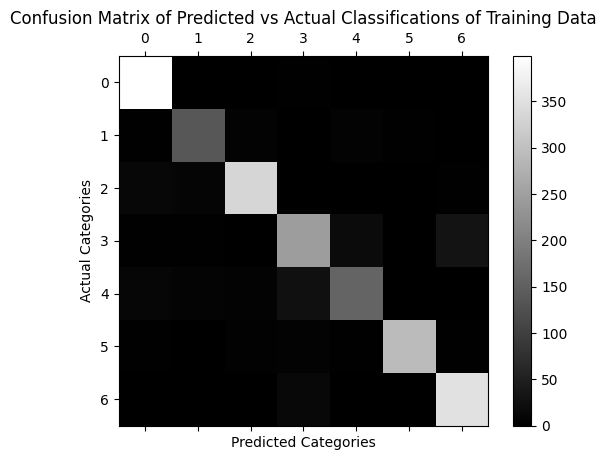

In [15]:
# Plots the confusion matrix to better visualize.
# Generally, the test data was classified correctly given the lighter colors in the diagonal.
fig = plt.figure()
ax = fig.add_subplot(111)
plot = ax.matshow(conf_matrix, cmap=plt.cm.gray)
fig.colorbar(plot)
ax.set_xlabel('Predicted Categories')
ax.set_ylabel('Actual Categories')
ax.set_title('Confusion Matrix of Predicted vs Actual Classifications of Training Data')

plt.show()

In [16]:
## 1. For each receipt we will take the avg(vendor embeddings, item1 embeddings, item2 embeddings, ...).
## 2. Pre-process the data to be put into the model.
## 3. Predict using the model.

In [15]:
test_arr = ["""{
  "ReceiptInfo": {
    "merchant": "SAFEWAY",
    "address": "2855 East Manoa Road",
    "city": "Honolulu",
    "state": "HI",
    "phoneNumber": "(808) 988-2058",
    "tax": "1.32",
    "total": "29.29",
    "receiptDate": "08/01/23",
    "receiptTime": "8:15pm",


    "ITEMS": [
      {
        "description": "MARINARA SCE",
        "quantity": "1",
        "unitPrice": "8.49",
        "totalPrice": "6.99",
        "discountAmount": "1.50"
      },
      {
        "description": "LUC CHES COLBY JAC.",
        "quantity": "1",
        "unitPrice": "13.49",
        "totalPrice": "10.99",
        "discountAmount": "2.50"
      },
      {
        "description": "MARIE CALLENDER'S",
        "quantity": "1",
        "unitPrice": "6.49",
        "totalPrice": "4.00",
        "discountAmount": "2.49"
      },
      {
        "description": "AIDELLS MEATBALLS",
        "quantity": "1",
        "unitPrice": "8.99",
        "totalPrice": "5.99",
        "discountAmount": "3.00"
      }
    ]
  }
}""",    
"""{
  "ReceiptInfo": {
    "merchant": "McDonald's Restaurant",
    "address": "2915 E MANOA RD",
    "city": "Honolulu",
    "state": "HI",
    "phoneNumber": "",
    "tax": "0.28",
    "total": "6.17",
    "receiptDate": "08/19/2023",
    "receiptTime": "03:33 PM",


    "ITEMS": [
      {
        "description": "1 Happy Meal Ch Burger",
        "quantity": "1",
        "unitPrice": "5.89",
        "totalPrice": "5.89",
        "discountAmount": "0.00"
      }
    ]
  }
}""",
"""{
  "ReceiptInfo": {
    "merchant": "Walmart",
    "address": "3549 RUSSETT GRN",
    "city": "LAUREL",
    "state": "MD",
    "phoneNumber": "301-604-0180",
    "tax": "0.12",
    "total": "22.08",
    "receiptDate": "07/04/23",
    "receiptTime": "4:20pm",


    "ITEMS": [
      {
        "description": "PRK SB",
        "quantity": "1",
        "unitPrice": "1.98",
        "totalPrice": "1.98",
        "discountAmount": "0.00"
      },
      {
        "description": "BOOSTER",
        "quantity": "1",
        "unitPrice": "19.98",
        "totalPrice": "19.98",
        "discountAmount": "0.00"
      }
    ]
  }
}"""]

In [18]:
def compute_embeddings(receipt):
    """Computes the embeddings for the vendor and items in the given receipt."""
    # Converts the receipt to JSON.
    try:
        json_object = json.loads(receipt)
    except:
        return None, None
    
    # Gets the vendor name from the receipt JSON object.
    vendor = json_object['ReceiptInfo']['merchant']
    embeddings_model = HuggingFaceEmbeddings()

    if vendor != "":
        # Gets embeddings for the vendor.
        vendor_embeddings = embeddings_model.embed_documents(vendor)[0]
    else:
        vendor_embeddings = None
    
    # Gets embeddings for items in receipt.
    items = [item['description'] for item in json_object['ReceiptInfo']['ITEMS']]
    embedded_items = embeddings_model.embed_documents(items)

    return vendor_embeddings, embedded_items

In [19]:
def get_avg_embeddings(vendor_embeddings, embedded_items):
    """Gets the average receipt embeddings"""
    avg_embeddings = []
    receipt_embeddings = {}

    if embedded_items is None and vendor_embeddings is None:
        return None
    elif len(embedded_items) == 0 and vendor_embeddings is not None:
        avg_embeddings = vendor_embeddings
    elif len(embedded_items) == 0 and vendor_embeddings is None:
        return None
    else:
        # For each embedding for the vendor.
        for i in range(len(embedded_items[0])):
    
            if vendor_embeddings is not None:
                # Add the embedding to embeddings.
                embeddings = [vendor_embeddings[i]]
            else:
                embeddings = []
        
            # Add all corresponding item embeddings to embeddings.
            for item_embedding in embedded_items:
                embeddings.append(item_embedding[i])
        
            # Add the average of the embedding to average embeddings.
            avg_embeddings.append(np.average(embeddings))
    
    # For each embedding add it to the embeddings object.
    for i in range(len(avg_embeddings)):
        if f'embedding_{i}' in receipt_embeddings:
            receipt_embeddings[f'embedding_{i}'].append(avg_embeddings[i])
        else:
            receipt_embeddings[f'embedding_{i}'] = []
            receipt_embeddings[f'embedding_{i}'].append(avg_embeddings[i])
    
    return receipt_embeddings

In [25]:
predicted_categories = []
category_counts = {}

# Gets a category prediction for each receipt.
for receipt in receipt_outputs:
    vendor_embeddings, embedded_items = compute_embeddings(receipt)
    avg_embeddings = get_avg_embeddings(vendor_embeddings, embedded_items)

    if avg_embeddings is not None:
        receipt_embeddings = pd.DataFrame(avg_embeddings)
        pred_category = knn_cls.predict(receipt_embeddings.to_numpy())[0]
        predicted_categories.append(pred_category)

    # Updates counts for categories predicted.
    if pred_category in category_counts:
        category_counts[pred_category] += 1
    else:
        category_counts[pred_category] = 1

/Users/charlierobison/opt/anaconda3/envs/temp/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/charlierobison/opt/anaconda3/envs/temp/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/charlierobison/opt/anaconda3/envs/temp/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/charlierobison/opt/anaconda3/envs/temp/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/charlierobison/opt/anaconda3/envs/temp/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid fe

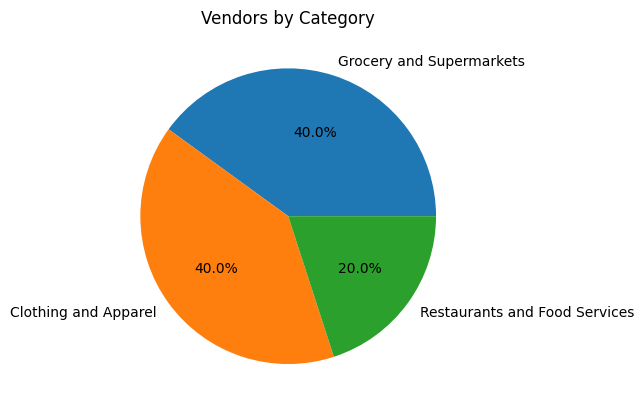

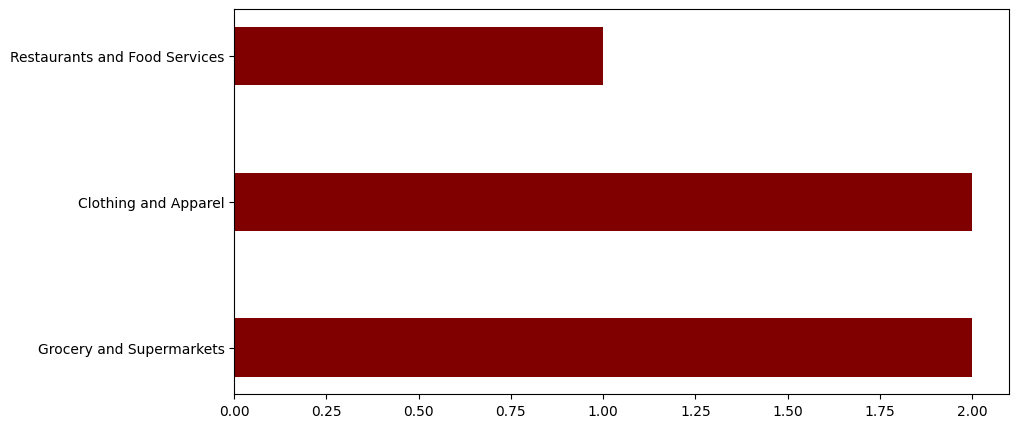

In [26]:
import matplotlib.pyplot as plt

#pie chart for vendor categories
labels = list(category_counts.keys())
values = list(category_counts.values())

fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%')
ax.set_title('Vendors by Category')


#bar graph for vendor categories
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.barh(labels, values, color ='maroon', 
        height = 0.4)

plt.show()

In [40]:
## Product Classification.

product_categories = ["Produce", "Dairy", "Fast Food", "Fine Dining", "Accessories", "Clothing", "Beauty Products", "Shower Products",
                      "Video Games", "Phones", "Appliances", "Tools", "Furniture", "Entertainment and Leisure"]

def get_product_training_data():
    folder_path = 'product_training_data/'
    category_train_test_data = {}
    category_training_items = []
    
    # List all files in the folder
    files = os.listdir(folder_path)
    i = 0

    # Gets the items for each category.
    for category in product_categories:
        # Gets the file identifier for the category.
        category_id = (category.split(" ")[0]).lower()
        file_name = f'{category_id}.txt'
        file_path = os.path.join(folder_path, file_name)
    
        # Check if it's a text file.
        if file_name.endswith('.txt'):
            with open(file_path, 'r') as file:
                # Read the content and split into list by newline character.
                text_content = file.read().split('\n')
                # Adds the items to the category in the dict.
                category_train_test_data[product_categories[i]] = text_content
                i += 1
    return category_train_test_data

prod_category_train_test_data = get_product_training_data()
prod_category_training_embeddings = {}

embeddings_model = HuggingFaceEmbeddings()

for category in prod_category_train_test_data:
    prod_category_training_embeddings[category] = embeddings_model.embed_documents(prod_category_train_test_data[category])
    
len(prod_category_training_embeddings["Produce"]), len(prod_category_training_embeddings)

(50, 14)

In [41]:
df_prod_category_items = []
d = {'categories':[]}

# Each category.
for category in prod_category_training_embeddings:
    # Each item in the category.
    for item in prod_category_training_embeddings[category]:
        df_prod_category_items.append(category)

        # Each embedding in an item.
        for i in range(len(item)):
            embedding = item[i]

            if f'embedding_{i}' in d:
                d[f'embedding_{i}'].append(embedding)
            else:
                d[f'embedding_{i}'] = []
                d[f'embedding_{i}'].append(embedding)

d['categories'] = df_prod_category_items
    
# Training and Testing data.
prod_category_data = pd.DataFrame(d)

prod_category_data.head()

,categories,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,Produce,0.000589,0.003567,-0.036941,-0.022206,0.002603,-0.011552,-0.024489,0.017725,0.035810,...,-0.060234,0.005869,0.038782,-0.017440,-0.002367,0.029283,0.004650,0.016896,0.004629,-0.008035
1,Produce,0.031964,0.005566,-0.023185,-0.053126,0.033858,-0.023757,-0.014453,0.007992,0.017826,...,-0.015866,-0.009298,-0.032220,-0.010490,0.004321,-0.033006,-0.023620,0.016731,-0.022331,-0.015998
2,Produce,0.064584,0.002496,-0.011188,-0.012615,0.030300,0.005024,-0.016991,0.045369,-0.023226,...,-0.051416,-0.021503,-0.000338,-0.001392,0.015543,0.065568,-0.014487,0.009346,-0.026118,-0.021456
3,Produce,0.007646,0.017002,-0.032329,-0.008278,-0.005862,0.004103,-0.004070,0.058659,0.059897,...,-0.021869,-0.005231,0.022821,-0.039141,0.001739,0.050639,0.011290,-0.035887,-0.014058,-0.038552
4,Produce,0.023380,0.070649,-0.030624,-0.020164,0.012016,-0.025285,0.023886,0.039508,0.047931,...,-0.036294,-0.010979,-0.019659,-0.026347,-0.010648,0.019826,-0.008819,0.004444,-0.032169,-0.018519


In [42]:
# Randomly shuffles the rows.
shuffled_data = prod_category_data.sample(frac=1)

total_rows = shuffled_data.shape[0]
train_size = int(total_rows*0.8)
 
# Split data into test and train
train = shuffled_data[0:train_size]
test = shuffled_data[train_size:]

train.head()

,categories,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
71,Dairy,0.011790,0.041808,0.004077,-0.044855,-0.029532,0.027526,-0.053275,0.040437,-0.109623,...,-0.029059,0.019530,0.051099,0.000496,0.003473,-0.017973,-0.026004,0.008704,0.043111,-0.009008
440,Video Games,-0.029374,-0.049545,-0.020544,-0.030302,-0.045945,0.002528,-0.027699,0.019472,0.040918,...,-0.037776,0.025112,-0.021757,0.004372,0.010226,-0.053091,0.004533,0.039495,-0.052280,-0.014353
342,Beauty Products,0.035088,0.017272,0.008351,-0.062070,-0.000771,-0.020342,0.028090,0.023251,-0.040403,...,-0.018843,-0.027240,-0.015597,-0.011543,-0.023101,-0.021738,-0.017668,0.008408,-0.086844,-0.052121
26,Produce,-0.025263,0.026598,-0.045838,0.023712,-0.014435,-0.012263,-0.025443,0.008347,0.020711,...,-0.043202,-0.014206,0.030665,-0.021370,0.013844,0.054126,-0.024224,0.014830,0.008010,-0.020969
203,Fine Dining,0.019598,-0.000285,0.002693,-0.051357,-0.036164,-0.034846,-0.079377,0.031062,-0.026862,...,-0.034549,-0.033007,0.035662,-0.055224,0.019339,0.090570,-0.002153,0.002100,0.041220,0.011911


In [43]:
# X is the embeddings and Y is the product categories.

y_train = train['categories']
x_train = train.loc[:, train.columns != 'categories']

y_test = test['categories']
x_test = test.loc[:, test.columns != 'categories']

In [44]:
knn = KNeighborsClassifier()

# Create a dictionary of all values we want to test for n_neighbors.
param_grid = {'n_neighbors': np.arange(1, 25)}

# Uses gridsearch to test all values for n_neighbors.
knn_grid_search = GridSearchCV(knn, param_grid, cv=5)

# Fit model to data.
knn_grid_search.fit(x_train, y_train)

# Gets the n_neighbors value which warrants the highest accuracy.
best_n_neighbors=knn_grid_search.best_params_['n_neighbors']
best_n_neighbors

15

In [45]:
# Trains the KNN model with the best n_neighbors value.
knn_cls_prod = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn_cls_prod.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=15)

In [47]:
from sklearn.metrics import confusion_matrix

# Gets the predications for the test dataset.
y_test_pred = knn_cls_prod.predict(x_test.to_numpy())

# Gets a confusion matrix for error analysis.
conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix

/Users/charlierobison/opt/anaconda3/envs/temp/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[ 5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  8,  0,  2,  1,  0,  0,  2,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  1,  1,  0,  4,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  1,  6,  0,  0,  3,  0,  0,  0],
       [ 1,  1,  0,  1,  0,  1,  0,  0,  7,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 12,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 12,  0,  0,  0],
       [ 1,  0,  5,  1,  0,  0,  0,  0,  0,  0,  0,  6,  0,  0],
       [ 2,  0,  1,  1,  0,  0,  0,  0,  1,  0,  0,  0,  7,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 12]])

In [48]:
# Gets precision, recall, and f1 score from the test data.
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='micro')
recall = recall_score(y_test, y_test_pred, average='micro')
# f1 = f1_score(y_test, y_test_pred, average='micro')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}. This high ratio assumes most postives were true positives since precision = tp / (tp + fp).')
print(f'Recall: {recall}. This high ratio means there were not too many false negatives since recalle = tp / (tp + fn).')
# print(f'F1 Score: {f1}. This high score means the model is relatively good at classifiying.')

Accuracy: 0.7535211267605634
Precision: 0.7535211267605634. This high ratio assumes most postives were true positives since precision = tp / (tp + fp).
Recall: 0.7535211267605634. This high ratio means there were not too many false negatives since recalle = tp / (tp + fn).


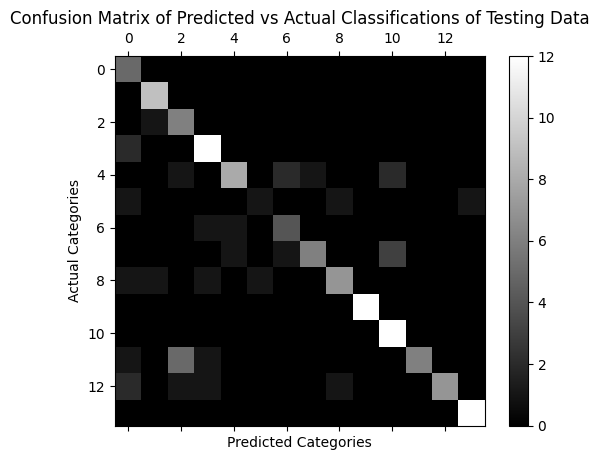

In [49]:
# Plots the confusion matrix to better visualize.
# Generally, the test data was classified correctly given the lighter colors in the diagonal.
# However some misclassifications.
fig = plt.figure()
ax = fig.add_subplot(111)
plot = ax.matshow(conf_matrix, cmap=plt.cm.gray)
fig.colorbar(plot)
ax.set_xlabel('Predicted Categories')
ax.set_ylabel('Actual Categories')
ax.set_title('Confusion Matrix of Predicted vs Actual Classifications of Testing Data')

plt.show()

In [50]:
test_items = ["Happy Meal Ch Burger", "MARINARA SCE", "HT VEGE DUMPLING"]

def compute_item_embeddings(item):
    embeddings_model = HuggingFaceEmbeddings()
    item_name = item['description']
    item_embeddings_obj = {}
    
    if item_name != "":
        # Gets embeddings for the item.
        item_embeddings = embeddings_model.embed_documents(item_name)[0]

        for i in range(len(item_embeddings)):
            if f'embeddings_{i}' in item_embeddings_obj:
                item_embeddings_obj[f'embeddings_{i}'].append(item_embeddings[i])
            else:
                item_embeddings_obj[f'embeddings_{i}'] = []
                item_embeddings_obj[f'embeddings_{i}'].append(item_embeddings[i])

    return item_embeddings_obj

In [52]:
product_predicted_categories = []
product_category_counts = {}

# Classifies category for each item in each receipt.
for receipt in test_arr:
    json_obj = json.loads(receipt)
    if 'ITEMS' in json_obj['ReceiptInfo']:
        for item in json_obj['ReceiptInfo']['ITEMS']:
            item_df = pd.DataFrame(compute_item_embeddings(item))
            pred_prod_category = knn_cls_prod.predict(item_df.to_numpy())[0]
            product_predicted_categories.append(pred_prod_category)

            # Keeps count of each category.
            if pred_prod_category in product_category_counts:
                product_category_counts[pred_prod_category] += 1
            else:
                product_category_counts[pred_prod_category] = 1
product_predicted_categories

/Users/charlierobison/opt/anaconda3/envs/temp/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/charlierobison/opt/anaconda3/envs/temp/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/charlierobison/opt/anaconda3/envs/temp/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/charlierobison/opt/anaconda3/envs/temp/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/charlierobison/opt/anaconda3/envs/temp/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid fe

['Dairy',
 'Fast Food',
 'Dairy',
 'Fast Food',
 'Phones',
 'Beauty Products',
 'Dairy']

In [ ]:
import matplotlib.pyplot as plt

#pie chart for vendor categories
labels = list(product_category_counts.keys())
values = list(product_category_counts.values())

fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%')
ax.set_title('Products by Category')


#bar graph for vendor categories
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.barh(labels, values, color ='maroon', 
        height = 0.4)

plt.show()

In [ ]:
## Named Entity Recognition:
def find_span(text, entity_text):
    """Finds the start and end positions for a given entity_text"""
    start = text.find(entity_text)
    if start == -1:
        return None
    end = start + len(entity_text)
    return (start, end), entity_text

def convert_to_prodigy_spans(receipt_text, entities):
    """Structures the receipt data by finding the position spans of each field indicated in the Structured JSON Object."""
    text_vals = []
    entities = json.loads(entities)
    prodigy_data = []
    receipt_info = entities["ReceiptInfo"]

    # Gets the label and entity_text for each corresponding label and entity listed.
    for label, entity_text in [
        ("MERCHANT", str(receipt_info.get("merchant", ""))), 
        ("ADDRESS", str(receipt_info.get("address", ""))), 
        ("CITY", str(receipt_info.get("city", ""))), 
        ("STATE", str(receipt_info.get("state", ""))), 
        ("PHONE", str(receipt_info.get("phoneNumber", ""))), 
        ("TAX", str(receipt_info.get("tax", ""))), 
        ("TOTAL", str(receipt_info.get("total", ""))), 
        ("DATE", str(receipt_info.get("receiptDate", ""))) 
    ]:

        # Tries to add positions of enties for corresponding labels.
        try:
            span, text = find_span(receipt_text, entity_text)
            text_vals.append(text)

            if span:
                start, end = span
                prodigy_data.append({"start": start, "end": end, "label": label})
        except:
            pass

    # Process item-level entities
    for item in receipt_info["ITEMS"]:
        for label, entity_text in [ # add .get() to all fields? 
            ("ITEM_DESC", item["description"]),
            ("QTY", str(item["quantity"])),
            ("UNIT_PRICE", str(item["unitPrice"])),
            ("TOTAL_PRICE", str(item["totalPrice"])),
            ("DISCOUNT", str(item.get("discountAmount", "")))  # Discount might not always be present
        ]:
            if entity_text:  # Check if the entity text is not empty
                span = find_span(receipt_text, entity_text)
                if span:
                    start, end = span
                    prodigy_data.append({"start": start, "end": end, "label": label})

    return prodigy_data, text_vals

# Example usage

prodigy_spans_true, text_vals = convert_to_prodigy_spans(test_receipts[0], receipt_outputs[0])
#print(json.dumps(prodigy_spans_true, indent=2))